In [141]:
import os
os.environ['TRANSFORMERS_CACHE'] ="/scratch/project_2007260/HF_cache"
os.environ['HF_DATASETS_CACHE'] ="/scratch/project_2007260/HF_cache"
os.environ['PYTHONPATH']="/scratch/project_2007260/miniconda/envs/py3.10"
os.environ['CONDA_PREFIX']="/scratch/project_2007260/miniconda/envs/py3.10"

In [142]:
# prompt: I want you to write a function that will take in as input a path to a directory. It has two folders "cn" and "ad". Each of htese contains folders. I want to create a csv which has two columns "ID" and "Dx". ID is the basename of the wavefile  inside cn and ad. and if the wavefile is from cn, Dx is "Control" and if the wavefile is from ad, the Dx value is "ProbableAD". Also, take as input the target path to the output csv

import os
import csv


def create_csv_from_directories(input_dir, output_csv_path):
    """
    Creates a CSV file with ID and Dx columns from wavefiles in 'cn' and 'ad' directories.

    Args:
        input_dir: Path to the input directory containing 'cn' and 'ad' subdirectories.
        output_csv_path: Path to the output CSV file.
    """

    with open(output_csv_path, 'w', newline='') as csvfile:
        fieldnames = ['ID', 'Dx']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for dx, label in [('cn', 'Control'), ('ad', 'ProbableAD')]:
            dir_path = os.path.join(input_dir, dx)

            for root, _, files in os.walk(dir_path):
                for file in files:
                  if file.endswith(".wav"): # Process only .wav files
                    base_name = os.path.splitext(file)[0]
                    writer.writerow({'ID': base_name, 'Dx': label})



In [143]:
# Example Usage (assuming you have mounted Google Drive and have directories set up):
input_directory = "/scratch/project_2007260/ADReSSo_Processed"  # Replace with your input directory path
output_csv_file = "ADReSSo/adresso_train_task.csv"  # Replace with your desired output CSV path

create_csv_from_directories(input_directory, output_csv_file)

In [144]:
import pandas as pd
import os
import random
import librosa
import numpy as np
import soundfile as sf


In [145]:
# prompt: I want to format  a string given adrsdt37, I want to convert it to adrso037. replace string with adrso and convert number to three digits. create a func to take this as input and give the new string

import re

def format_string(input_string):
    """
    Formats a string in the forma
    t 'adrsdt##' to 'adrso###',
    where '#' represents a digit, and the number is zero-padded to three digits.

    Args:
        input_string: The input string to format.

    Returns:
        The formatted string, or the original string if it doesn't match the expected pattern.
    """
    match = re.match(r"adrsdt(\d+)", input_string)
    if match:
        number = int(match.group(1))
        formatted_number = str(number).zfill(3)
        return "adrso" + formatted_number
    else:
        return input_string

# Example usage
input_string = "adrsdt37"
formatted_string = format_string(input_string)
print(f"Original string: {input_string}")
print(f"Formatted string: {formatted_string}")

input_string = "adrsdt1"
formatted_string = format_string(input_string)
print(f"Original string: {input_string}")
print(f"Formatted string: {formatted_string}")

input_string = "adrsdt123"
formatted_string = format_string(input_string)
print(f"Original string: {input_string}")
print(f"Formatted string: {formatted_string}")

Original string: adrsdt37
Formatted string: adrso037
Original string: adrsdt1
Formatted string: adrso001
Original string: adrsdt123
Formatted string: adrso123


In [146]:
root_data_dir = "/scratch/project_2007260/ADReSSo/ADReSSo21/Dhinirnaya_chunk"

# Function to add Gaussian noise to an audio segment
def add_gaussian_noise(audio, std=0.005):
    noise = np.random.normal(0, std, audio.shape)
    return audio + noise



# Function to randomly apply augmentation to each chunk
def augment_chunk(chunk, sr):
    augmentation_type = random.choice(['none', 'speed', 'noise'])
    if augmentation_type == 'noise':
        chunk = add_gaussian_noise(chunk)
    elif augmentation_type == 'speed':
        # Uncomment the line below if you want to apply speed perturbation
        speed_factor = random.uniform(0.9, 1.1)
        chunk = apply_speed_perturbation(chunk, speed_factor)
    return chunk

In [147]:
import os
import pandas as pd
import random
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm

def generate_paths_adresso(output_dir, root_dir="/scratch/project_2007260/ADReSSo/ADReSSo21/diagnosis", mode='train', csv_path="", chunk=True):
    data = pd.read_csv(csv_path)
    data.loc[data['Dx'] == 'Control', 'Dx'] = 'HC'
    data.loc[data['Dx'] == 'ProbableAD', 'Dx'] = 'Dementia'

    data_list = []
    num_files_not_found = 0

    for index, row in tqdm(data.iterrows()):
        orig_record_id = row['ID']
        label = row['Dx']

        if mode == 'test-dist':
          record_id = orig_record_id
        else:
          record_id = format_string(orig_record_id)
        print(record_id, label)

        audio_dir = 'audio'
        seg_dir = 'segmentation'
        if label == 'HC':
            if mode == 'train':
                audio_dir = 'audio/cn'
                seg_dir = 'segmentation/cn'
            audio_path = os.path.join(f'/scratch/project_2007260/ADReSSo/ADReSSo21/diagnosis/{mode}/{audio_dir}', f'{record_id}.wav')
            seg_path = os.path.join(f'/scratch/project_2007260/ADReSSo/ADReSSo21/diagnosis/{mode}/{seg_dir}', f'{record_id}.csv')
            numerical_label = 0
        elif label == 'Dementia':
            if mode == 'train':
                audio_dir = 'audio/ad'
                seg_dir = 'segmentation/ad'
            audio_path = os.path.join(f'/scratch/project_2007260/ADReSSo/ADReSSo21/diagnosis/{mode}/{audio_dir}', f'{record_id}.wav')
            seg_path = os.path.join(f'/scratch/project_2007260/ADReSSo/ADReSSo21/diagnosis/{mode}/{seg_dir}', f'{record_id}.csv')
            numerical_label = 1
        else:
            continue

        try:

            y, sr = librosa.load(audio_path, sr=16000)
            segments = pd.read_csv(seg_path)
            segments = segments[segments['speaker'] == 'PAR']

            index = 0
            concat_audio = None
            print("Chunk is: ", chunk)

            for idx, segment in segments.iterrows():

                chunk_path = os.path.join(output_dir, f'{record_id}_adresso_chunk_{index}.wav')
                start_time = int(segment['begin']) / 1000
                end_time = int(segment['end']) / 1000

                if chunk:

                  if (end_time - start_time) >= 1:
                    if not os.path.exists(chunk_path):

                      chunk = y[int(start_time * sr) : int(end_time * sr)]

                      chunk = augment_chunk(chunk, sr)
                      sf.write(chunk_path, chunk, sr)

                    data_list.append({
                        'audio_path': chunk_path,
                        'text_path': None,
                        'label': numerical_label,
                        'task_type': 'adresso'
                    })
                    index += 1
                else:
                  if concat_audio is None:
                    concat_audio = y[int(start_time * sr) : int(end_time * sr)]
                  else:
                    concat_audio = np.concatenate((concat_audio, y[int(start_time * sr) : int(end_time * sr)]))

            if concat_audio is not None:
              concat_audio_path = os.path.join(output_dir, f'{record_id}_adresso_concat.wav')
              concat_augment = augment_chunk(concat_audio, sr)
              sf.write(concat_audio_path, concat_augment, sr)
              data_list.append({
                  'audio_path': concat_audio_path,
                  'text_path': None,
                  'label': numerical_label,
                  'task_type': 'adresso'
              })


        except FileNotFoundError:
            print(f"File not found: {audio_path} or {seg_path}")
            num_files_not_found += 1
            continue
    print("Number of files not found: ", num_files_not_found)

    return data_list

In [148]:
adresso_test_list = generate_paths_adresso(
    '/scratch/project_2007260/ADReSSo/ADReSSo21/Dhinirnaya_chunk',
    mode='test-dist',
    csv_path='/scratch/project_2007260/ADReSSo/ADReSSo21/task1.csv',
    chunk=False
)

0it [00:00, ?it/s]

adrsdt15 HC
Chunk is:  False


2it [00:00,  2.93it/s]

adrsdt40 HC
Chunk is:  False
adrsdt26 HC


3it [00:01,  3.34it/s]

Chunk is:  False
adrsdt67 HC
Chunk is:  False


4it [00:01,  3.96it/s]

adrsdt58 HC


5it [00:01,  3.61it/s]

Chunk is:  False
adrsdt49 HC


6it [00:01,  3.85it/s]

Chunk is:  False
adrsdt46 Dementia
Chunk is:  False


7it [00:02,  1.76it/s]

adrsdt8 Dementia


8it [00:03,  2.08it/s]

Chunk is:  False
adrsdt64 Dementia


9it [00:03,  2.55it/s]

Chunk is:  False
adrsdt29 Dementia


10it [00:03,  2.60it/s]

Chunk is:  False
adrsdt59 Dementia


11it [00:04,  2.98it/s]

Chunk is:  False
adrsdt18 Dementia


12it [00:04,  2.49it/s]

Chunk is:  False
adrsdt44 Dementia


13it [00:04,  2.65it/s]

Chunk is:  False
adrsdt61 Dementia


14it [00:05,  2.78it/s]

Chunk is:  False
adrsdt37 Dementia


15it [00:05,  3.10it/s]

Chunk is:  False
adrsdt32 Dementia


16it [00:05,  3.12it/s]

Chunk is:  False
adrsdt62 Dementia
Chunk is:  False


17it [00:06,  2.51it/s]

adrsdt71 Dementia
Chunk is:  False


18it [00:06,  2.76it/s]

adrsdt24 Dementia
Chunk is:  False


19it [00:06,  2.84it/s]

adrsdt63 Dementia


20it [00:07,  3.06it/s]

Chunk is:  False
adrsdt1 Dementia


21it [00:07,  3.37it/s]

Chunk is:  False
adrsdt13 Dementia


22it [00:07,  3.31it/s]

Chunk is:  False
adrsdt19 Dementia
Chunk is:  False


24it [00:08,  3.55it/s]

adrsdt14 Dementia
Chunk is:  False
adrsdt2 Dementia


25it [00:08,  3.46it/s]

Chunk is:  False
adrsdt16 Dementia


26it [00:08,  3.97it/s]

Chunk is:  False
adrsdt41 Dementia


28it [00:09,  2.81it/s]

Chunk is:  False
adrsdt7 Dementia
Chunk is:  False
adrsdt39 Dementia


29it [00:10,  3.17it/s]

Chunk is:  False
adrsdt38 HC
Chunk is:  False


30it [00:10,  2.57it/s]

adrsdt30 HC
Chunk is:  False


31it [00:10,  2.80it/s]

adrsdt52 HC


32it [00:11,  2.76it/s]

Chunk is:  False
adrsdt65 HC


33it [00:11,  2.77it/s]

Chunk is:  False
adrsdt10 HC


35it [00:12,  3.46it/s]

Chunk is:  False
adrsdt42 HC
Chunk is:  False
adrsdt21 HC


36it [00:12,  4.15it/s]

Chunk is:  False
adrsdt11 HC


37it [00:12,  3.15it/s]

Chunk is:  False
adrsdt17 HC
Chunk is:  False


38it [00:13,  2.11it/s]

adrsdt20 Dementia
Chunk is:  False


40it [00:14,  2.63it/s]

adrsdt28 Dementia
Chunk is:  False
adrsdt23 Dementia


42it [00:14,  3.58it/s]

Chunk is:  False
adrsdt70 Dementia
Chunk is:  False
adrsdt33 Dementia


43it [00:14,  3.69it/s]

Chunk is:  False
adrsdt4 Dementia
Chunk is:  False


44it [00:15,  3.60it/s]

adrsdt57 Dementia
Chunk is:  False


45it [00:15,  3.76it/s]

adrsdt35 Dementia
Chunk is:  False


46it [00:15,  3.45it/s]

adrsdt9 Dementia
Chunk is:  False


48it [00:16,  4.28it/s]

adrsdt60 Dementia
Chunk is:  False
adrsdt25 Dementia
Chunk is:  False


50it [00:17,  3.01it/s]

adrsdt34 Dementia
Chunk is:  False
adrsdt27 HC


51it [00:17,  3.14it/s]

Chunk is:  False
adrsdt54 HC


52it [00:17,  3.43it/s]

Chunk is:  False
adrsdt66 HC


53it [00:17,  3.42it/s]

Chunk is:  False
adrsdt45 HC


54it [00:18,  4.13it/s]

Chunk is:  False
adrsdt56 HC


55it [00:18,  3.63it/s]

Chunk is:  False
adrsdt43 HC
Chunk is:  False


57it [00:18,  4.06it/s]

adrsdt51 HC
Chunk is:  False
adrsdt50 HC
Chunk is:  False


58it [00:19,  2.67it/s]

adrsdt53 HC
Chunk is:  False


60it [00:19,  3.42it/s]

adrsdt69 HC
Chunk is:  False
adrsdt6 HC


61it [00:21,  1.72it/s]

Chunk is:  False
adrsdt12 HC


62it [00:21,  2.12it/s]

Chunk is:  False
adrsdt36 HC


63it [00:21,  2.28it/s]

Chunk is:  False
adrsdt3 HC
Chunk is:  False


64it [00:21,  2.74it/s]

adrsdt47 HC


65it [00:22,  2.06it/s]

Chunk is:  False
adrsdt22 HC


66it [00:23,  2.40it/s]

Chunk is:  False
adrsdt55 HC


67it [00:23,  2.79it/s]

Chunk is:  False
adrsdt68 HC


68it [00:23,  3.07it/s]

Chunk is:  False
adrsdt31 HC


70it [00:24,  3.57it/s]

Chunk is:  False
adrsdt5 HC
Chunk is:  False
adrsdt48 HC


71it [00:24,  2.93it/s]

Chunk is:  False
Number of files not found:  0


In [149]:
dev_adresso_path = os.path.join(root_data_dir, 'dev_adresso_concat.csv')
pd.DataFrame(adresso_test_list).to_csv(dev_adresso_path, index=False)

In [150]:
adresso_train_list = generate_paths_adresso(
  '/scratch/project_2007260/ADReSSo/ADReSSo21/Dhinirnaya_chunk/adresso_concat',
  csv_path='/scratch/project_2007260/ADReSSo/adresso_train_task.csv',
  mode='train',
  chunk=False
)

0it [00:00, ?it/s]

adrso270 HC


1it [00:00,  1.60it/s]

Chunk is:  False
adrso017 HC


2it [00:00,  2.50it/s]

Chunk is:  False
adrso300 HC


3it [00:01,  2.42it/s]

Chunk is:  False
adrso160 HC
Chunk is:  False


4it [00:01,  2.73it/s]

adrso167 HC
Chunk is:  False


5it [00:02,  2.27it/s]

adrso308 HC


6it [00:02,  2.12it/s]

Chunk is:  False
adrso021 HC


7it [00:02,  2.73it/s]

Chunk is:  False
adrso012 HC
Chunk is:  False


8it [00:03,  2.06it/s]

adrso008 HC


9it [00:03,  2.30it/s]

Chunk is:  False
adrso153 HC


10it [00:04,  2.47it/s]

Chunk is:  False
adrso283 HC


11it [00:04,  2.83it/s]

Chunk is:  False
adrso264 HC


12it [00:04,  2.86it/s]

Chunk is:  False
adrso169 HC


13it [00:04,  3.49it/s]

Chunk is:  False
adrso010 HC
Chunk is:  False


15it [00:05,  4.28it/s]

adrso263 HC
Chunk is:  False
adrso162 HC


16it [00:05,  3.87it/s]

Chunk is:  False
adrso018 HC


17it [00:05,  4.49it/s]

Chunk is:  False
adrso161 HC


18it [00:06,  3.61it/s]

Chunk is:  False
adrso286 HC


19it [00:06,  4.09it/s]

Chunk is:  False
adrso172 HC


20it [00:06,  3.36it/s]

Chunk is:  False
adrso152 HC
Chunk is:  False


21it [00:06,  3.83it/s]

adrso182 HC
Chunk is:  False


23it [00:07,  4.88it/s]

adrso015 HC
Chunk is:  False
adrso159 HC


24it [00:07,  5.11it/s]

Chunk is:  False
adrso016 HC


25it [00:07,  4.78it/s]

Chunk is:  False
adrso183 HC
Chunk is:  False


27it [00:08,  4.13it/s]

adrso023 HC
Chunk is:  False
adrso285 HC


28it [00:08,  4.60it/s]

Chunk is:  False
adrso177 HC


29it [00:08,  3.73it/s]

Chunk is:  False
adrso261 HC


30it [00:09,  3.71it/s]

Chunk is:  False
adrso003 HC
Chunk is:  False


32it [00:09,  4.59it/s]

adrso154 HC
Chunk is:  False
adrso298 HC


33it [00:09,  3.90it/s]

Chunk is:  False
adrso315 HC


34it [00:09,  4.38it/s]

Chunk is:  False
adrso278 HC


35it [00:10,  2.90it/s]

Chunk is:  False
adrso260 HC
Chunk is:  False


37it [00:10,  3.79it/s]

adrso014 HC
Chunk is:  False
adrso277 HC


38it [00:11,  4.20it/s]

Chunk is:  False
adrso296 HC
Chunk is:  False


39it [00:11,  3.78it/s]

adrso257 HC


40it [00:11,  3.08it/s]

Chunk is:  False
adrso274 HC


41it [00:12,  2.87it/s]

Chunk is:  False
adrso005 HC
Chunk is:  False


42it [00:12,  2.32it/s]

adrso266 HC
Chunk is:  False


44it [00:13,  3.12it/s]

adrso170 HC
Chunk is:  False
adrso007 HC


45it [00:14,  2.22it/s]

Chunk is:  False
adrso173 HC


46it [00:14,  2.44it/s]

Chunk is:  False
adrso267 HC


47it [00:14,  2.76it/s]

Chunk is:  False
adrso292 HC
Chunk is:  False


49it [00:15,  3.46it/s]

adrso307 HC
Chunk is:  False
adrso312 HC


50it [00:15,  3.67it/s]

Chunk is:  False
adrso291 HC


51it [00:15,  3.72it/s]

Chunk is:  False
adrso002 HC


52it [00:16,  3.16it/s]

Chunk is:  False
adrso019 HC


53it [00:16,  2.80it/s]

Chunk is:  False
adrso280 HC
Chunk is:  False


54it [00:16,  2.99it/s]

adrso180 HC
Chunk is:  False


55it [00:17,  3.35it/s]

adrso302 HC
Chunk is:  False


56it [00:17,  3.46it/s]

adrso164 HC
Chunk is:  False


57it [00:17,  3.07it/s]

adrso299 HC
Chunk is:  False


58it [00:17,  3.27it/s]

adrso289 HC


59it [00:18,  3.20it/s]

Chunk is:  False
adrso309 HC
Chunk is:  False


60it [00:18,  3.82it/s]

adrso157 HC


61it [00:18,  3.24it/s]

Chunk is:  False
adrso158 HC


62it [00:19,  3.36it/s]

Chunk is:  False
adrso259 HC


63it [00:19,  3.06it/s]

Chunk is:  False
adrso165 HC
Chunk is:  False


65it [00:19,  4.23it/s]

adrso262 HC
Chunk is:  False
adrso310 HC


66it [00:20,  3.61it/s]

Chunk is:  False
adrso148 HC


67it [00:20,  3.05it/s]

Chunk is:  False
adrso022 HC


68it [00:20,  3.85it/s]

Chunk is:  False
adrso316 HC


69it [00:20,  3.75it/s]

Chunk is:  False
adrso265 HC


70it [00:21,  3.16it/s]

Chunk is:  False
adrso281 HC


71it [00:21,  3.41it/s]

Chunk is:  False
adrso168 HC
Chunk is:  False


72it [00:22,  2.83it/s]

adrso178 HC
Chunk is:  False


73it [00:22,  3.20it/s]

adrso268 HC


74it [00:22,  3.08it/s]

Chunk is:  False
adrso273 HC


75it [00:22,  3.30it/s]

Chunk is:  False
adrso276 HC


76it [00:23,  3.48it/s]

Chunk is:  False
adrso186 HC


77it [00:23,  4.11it/s]

Chunk is:  False
adrso156 HC


78it [00:23,  3.63it/s]

Chunk is:  False
adrso151 HC


79it [00:23,  4.16it/s]

Chunk is:  False
adrso033 Dementia


80it [00:24,  3.96it/s]

Chunk is:  False
adrso247 Dementia


81it [00:24,  3.36it/s]

Chunk is:  False
adrso074 Dementia


82it [00:24,  3.66it/s]

Chunk is:  False
adrso198 Dementia


83it [00:25,  3.48it/s]

Chunk is:  False
adrso188 Dementia


84it [00:25,  2.35it/s]

Chunk is:  False
adrso249 Dementia


85it [00:26,  2.18it/s]

Chunk is:  False
adrso047 Dementia


86it [00:27,  1.29it/s]

Chunk is:  False
adrso043 Dementia


87it [00:28,  1.59it/s]

Chunk is:  False
adrso189 Dementia
Chunk is:  False


88it [00:28,  1.65it/s]

adrso141 Dementia


89it [00:29,  1.65it/s]

Chunk is:  False
adrso045 Dementia


90it [00:29,  1.78it/s]

Chunk is:  False
adrso216 Dementia
Chunk is:  False


91it [00:30,  1.78it/s]

adrso250 Dementia


92it [00:31,  1.69it/s]

Chunk is:  False
adrso223 Dementia
Chunk is:  False


93it [00:31,  1.71it/s]

adrso187 Dementia
Chunk is:  False


94it [00:31,  2.05it/s]

adrso055 Dementia
Chunk is:  False


95it [00:32,  2.42it/s]

adrso138 Dementia
Chunk is:  False


96it [00:32,  2.81it/s]

adrso211 Dementia
Chunk is:  False


98it [00:32,  3.58it/s]

adrso234 Dementia
Chunk is:  False
adrso090 Dementia


99it [00:33,  3.51it/s]

Chunk is:  False
adrso128 Dementia
Chunk is:  False


100it [00:33,  2.64it/s]

adrso123 Dementia
Chunk is:  False


101it [00:33,  3.06it/s]

adrso093 Dementia
Chunk is:  False


102it [00:34,  3.17it/s]

adrso244 Dementia
Chunk is:  False


104it [00:35,  2.73it/s]

adrso125 Dementia
Chunk is:  False
adrso190 Dementia


105it [00:35,  2.61it/s]

Chunk is:  False
adrso032 Dementia


106it [00:35,  2.80it/s]

Chunk is:  False
adrso109 Dementia


107it [00:36,  3.13it/s]

Chunk is:  False
adrso046 Dementia


108it [00:36,  3.12it/s]

Chunk is:  False
adrso232 Dementia


109it [00:36,  3.30it/s]

Chunk is:  False
adrso075 Dementia


110it [00:36,  3.95it/s]

Chunk is:  False
adrso192 Dementia


111it [00:37,  2.65it/s]

Chunk is:  False
adrso220 Dementia


112it [00:37,  2.57it/s]

Chunk is:  False
adrso060 Dementia
Chunk is:  False


113it [00:37,  3.27it/s]

adrso134 Dementia


115it [00:38,  3.51it/s]

Chunk is:  False
adrso036 Dementia
Chunk is:  False
adrso212 Dementia
Chunk is:  False


116it [00:39,  2.81it/s]

adrso031 Dementia


117it [00:39,  2.45it/s]

Chunk is:  False
adrso206 Dementia
Chunk is:  False


119it [00:40,  2.39it/s]

adrso059 Dementia
Chunk is:  False
adrso068 Dementia


121it [00:40,  3.35it/s]

Chunk is:  False
adrso237 Dementia
Chunk is:  False
adrso246 Dementia


122it [00:41,  4.02it/s]

Chunk is:  False
adrso197 Dementia


123it [00:41,  3.16it/s]

Chunk is:  False
adrso039 Dementia


124it [00:41,  3.15it/s]

Chunk is:  False
adrso025 Dementia


125it [00:42,  2.70it/s]

Chunk is:  False
adrso126 Dementia


127it [00:42,  3.73it/s]

Chunk is:  False
adrso092 Dementia
Chunk is:  False
adrso205 Dementia


128it [00:43,  3.28it/s]

Chunk is:  False
adrso024 Dementia


129it [00:43,  2.72it/s]

Chunk is:  False
adrso110 Dementia


130it [00:43,  3.31it/s]

Chunk is:  False
adrso089 Dementia
Chunk is:  False


131it [00:44,  2.39it/s]

adrso054 Dementia
Chunk is:  False


132it [00:45,  1.51it/s]

adrso078 Dementia


133it [00:46,  1.56it/s]

Chunk is:  False
adrso063 Dementia


134it [00:46,  1.70it/s]

Chunk is:  False
adrso106 Dementia


135it [00:47,  1.87it/s]

Chunk is:  False
adrso209 Dementia


136it [00:47,  2.21it/s]

Chunk is:  False
adrso222 Dementia
Chunk is:  False


137it [00:47,  2.87it/s]

adrso098 Dementia


138it [00:47,  3.00it/s]

Chunk is:  False
adrso228 Dementia
Chunk is:  False


140it [00:48,  3.80it/s]

adrso116 Dementia
Chunk is:  False
adrso142 Dementia


141it [00:48,  4.44it/s]

Chunk is:  False
adrso027 Dementia


142it [00:48,  4.12it/s]

Chunk is:  False
adrso028 Dementia


143it [00:48,  4.24it/s]

Chunk is:  False
adrso202 Dementia


144it [00:49,  3.44it/s]

Chunk is:  False
adrso035 Dementia


145it [00:49,  3.18it/s]

Chunk is:  False
adrso122 Dementia


146it [00:49,  3.18it/s]

Chunk is:  False
adrso049 Dementia


147it [00:50,  3.19it/s]

Chunk is:  False
adrso248 Dementia
Chunk is:  False


148it [00:50,  2.64it/s]

adrso053 Dementia
Chunk is:  False


149it [00:51,  2.76it/s]

adrso130 Dementia
Chunk is:  False


151it [00:51,  3.67it/s]

adrso112 Dementia
Chunk is:  False
adrso200 Dementia


152it [00:51,  3.20it/s]

Chunk is:  False
adrso245 Dementia
Chunk is:  False


153it [00:52,  3.84it/s]

adrso253 Dementia


154it [00:52,  3.34it/s]

Chunk is:  False
adrso072 Dementia
Chunk is:  False


155it [00:52,  4.02it/s]

adrso229 Dementia


157it [00:52,  4.63it/s]

Chunk is:  False
adrso236 Dementia
Chunk is:  False
adrso233 Dementia


158it [00:53,  4.28it/s]

Chunk is:  False
adrso218 Dementia
Chunk is:  False


159it [00:53,  4.72it/s]

adrso056 Dementia
Chunk is:  False


160it [00:54,  1.89it/s]

adrso215 Dementia


161it [00:55,  2.04it/s]

Chunk is:  False
adrso070 Dementia
Chunk is:  False


162it [00:55,  2.58it/s]

adrso071 Dementia
Chunk is:  False


164it [00:55,  3.60it/s]

adrso224 Dementia
Chunk is:  False
adrso144 Dementia


165it [00:55,  4.26it/s]

Chunk is:  False
adrso077 Dementia


166it [00:55,  2.97it/s]

Chunk is:  False
Number of files not found:  0


In [151]:
train_adresso_path = os.path.join(root_data_dir, 'train_adresso_concat.csv')
pd.DataFrame(adresso_train_list).to_csv(train_adresso_path, index=False)

In [152]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 27 23:19:05 2023

@author: self
"""

import librosa
import numpy as np
import pysptk

def f0estimate_rapt(path, fs):
    data_audio, fs = librosa.load(path, sr=fs) 
    data_audio=data_audio-np.mean(data_audio)
    data_audio=data_audio/float(np.max(np.abs(data_audio)))

    size_frame=0.03 # sec
    size_step=0.01 # sec
    minf0=60 #hz
    maxf0=350 #hz
    voice_bias=-0.2
    size_frameS=size_frame*float(fs)
    size_stepS=size_step*float(fs)
    overlap=size_stepS/size_frameS
    #nF=int((len(data_audio)/size_frameS/overlap))-1
    data_audiof=np.asarray(data_audio, dtype=np.float32)

    # Calculate frame rate
    frame_rate = fs / (overlap * size_frameS)
    #print("Frame rate for F0:", frame_rate, "Hz")
    F0=pysptk.sptk.rapt(data_audiof*(2**15), fs, int(size_stepS), min=minf0, max=maxf0, voice_bias=voice_bias, otype='f0')
    
    return F0, frame_rate, size_stepS

In [153]:
# rfa_single_conf.py
# Dafydd Gibbon
# Created 2021-08-16
# Modified 2022-04-18
# Code first deposited on GitHub 2021-08-16
# http://www.github.com/dafyddg/RFA
# Variable assignments for rfa_single.py
# See top level README.1st file.

"""
Note that the F0 parameters are defined in the F0 module, not here.
"""

"""
MIT license
Begin license text.
Copyright 2021 Dafydd Gibbon
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
End license text.
"""

# CSV separator
separator = ","

# Figure show and size
showgraph = True
figwidth = 5
figheight = 4

# Dendrogram box dimensions and position (AM)
amboxwidth = 0.45
amboxheight = 0.07
amboxx = 0.53
amboxy = 0.25

# Dendrogram box dimensions and position (FM)

fmboxwidth = 0.45
fmboxheight = 0.07
fmboxx = 0.53
fmboxy = 0.1

# Column chart resolution
bincount = 40

# Envelope superposition flag (spectrograms, formant tracks)
envelopeoverlay = True

# Waterfall or column chart display switch
waterfall = False

# Waterfall parameters
waterfallincplus = 2
specheatmaptype = "YlOrRd"
specgramdotsize = 60
fontsize = 10

# Minimum and maximum spectrum and spectrogram frequencies, default: amspecfreqmax=5
amspecfreqmin = 0
amspecfreqmax = 10

fmspecfreqmin = 0
fmspecfreqmax = 10 #default: fmspecfreqmax=5

# Minimum value of spectral magnitude line for formants
amformantlimit = 0.3
fmformantlimit = 0.3

# Number of spectral magnitude peaks marked in spectrum display
magscount = 6

# Optional high magnitude emphasis
spectrumpower = 1

# Optional brute force downsampling factor (spectral analysis)
# This is not true downsampling, but stepping interval selection
specdownsample = 4

# Choose number of equally spaced rows in spectrogram matrix (default 50)
specstrides = 50	# yields same length spectrograms, for comparison

# EOF

In [154]:
#===============================================================

import numpy as np
#===============================================================
#===============================================================
# System and library module import
from scipy.signal import find_peaks
import sys, re
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
from scipy.signal import butter, lfilter
from datetime import datetime
import librosa
# RFA custom module import
#===============================================================
# Assign configuration parameters to variables (see .conf file)

#===============================================================
def spectrogramarray_v1(signal, fs, specfreqmin, specfreqmax, specdownsample, spectrumpower, specwindowsecs, specstrides):

	# Brute force downsampling, optional
	#signal = signal[::specdownsample]
	#fs = int(round(fs/specdownsample))
	period = 1/fs
	signallen = len(signal)
	signalsecs = int(round(signallen / fs))

	#============================================
	windowlen = int(round(specwindowsecs * fs))	# window length sec -> sample
	signalleneffective = signallen - windowlen	# first to last stride pos
	stride = int(round(signalleneffective / specstrides))	# time step

	# Moving window
	# Stride start and end counters
	counterstart = np.array(range(0,signalleneffective,stride))	# start & end
	counterend = counterstart + windowlen

	magarray = []
	freqarray = []
	for countstart,countend in zip(counterstart,counterend):
		segment = np.abs(signal[countstart:countend])				# window-length segment
		segment = list(segment)
		segment = segment
		segment = np.array(segment)
		mags = abs(np.fft.rfft(segment))						# FFT magnitudes
		freqs = np.abs(np.fft.rfftfreq(segment.size,period))	# FFT frequencies
#		freqs = np.linspace(0, fs/2, len(mags))
		magarray += [ mags ]								# collect FFTs
		freqarray += [ freqs ]

	#============================================
	# Spectrum properties

	spectrummax = int(round(fs/2))
	rowlen = len(freqarray[0])
	elementsperhertz = int(round( rowlen / spectrummax ))

#	print("Elements per hertz:", elementsperhertz)
	xmin = specfreqmin * elementsperhertz
	xmax = specfreqmax * elementsperhertz
	sfmin = int(np.floor(xmin))
	sfmax = int(np.ceil(xmax))
	magarray = np.array([ x[sfmin:sfmax] for x in magarray ])**spectrumpower
	freqarray = [ x[sfmin:sfmax] for x in freqarray ]

	#Detect maximum vector through spectrogram
	maxmags = np.array([ max(mags[1:]) for mags in magarray ])
#	print(maxmags.shape)

	#============================================
	# Loop to define spectrogram as a spectrum sequence
	maxfreqs = []
	for mags, freqs in zip(magarray, freqarray):
		maxofmags = np.max(mags)
		# An error with a very deep voice (60Hz) threw an error
		if maxofmags == 0.0: maxofmags = 0.0001	# a hack, sorry
		mags = mags/maxofmags
		mags = list(mags[1:])
		maxmag = np.max(mags)
		maxmagpos = mags.index(maxmag)
		maxfreq = freqs[maxmagpos]
		maxmags += [maxmag]
		maxfreqs += [maxfreq]

	return np.array(magarray), np.array(freqarray), maxmags, maxfreqs

def spectrogramarray_v2(signal, fs, specfreqmin, specfreqmax, specdownsample, spectrumpower, specwindowsecs, specstrides):

    # Brute force downsampling, optional
    # signal = signal[::specdownsample]
    # fs = int(round(fs/specdownsample))
    period = 1/fs
    signallen = len(signal)
    signalsecs = int(round(signallen / fs))

    #============================================
    windowlen = int(round(specwindowsecs * fs))  # window length in samples
    signalleneffective = signallen - windowlen  # first to last stride pos
    stride = int(round(signalleneffective / specstrides))  # time step

    # Moving window
    # Stride start and end counters
    counterstart = np.array(range(0, signalleneffective, stride))  # start positions
    counterend = counterstart + windowlen  # end positions

    magarray = []
    freqarray = []
    for countstart, countend in zip(counterstart, counterend):
        segment = signal[countstart:countend]  # window-length segment
        segment = np.array(segment)
        mags = np.abs(np.fft.rfft(segment))  # FFT magnitudes
        freqs = np.fft.rfftfreq(segment.size, period)  # FFT frequencies
        magarray.append(mags)  # collect FFTs
        freqarray.append(freqs)

    #============================================
    # Interpolate magnitude spectra to have 224 frequency bins

    # Desired frequency range (ensure it includes 10 Hz)
    specfreqmin = max(specfreqmin, 0)  # Minimum frequency (e.g., 0 Hz)
    specfreqmax = max(specfreqmax, 10)  # Ensure at least up to 10 Hz

    # Create a common frequency axis with 224 points
    num_freq_bins = 224
    new_freqs = np.linspace(specfreqmin, specfreqmax, num_freq_bins)

    magarray_resampled = []
    for mags, freqs in zip(magarray, freqarray):
        # Interpolate magnitudes to the new frequency axis
        mags_interpolated = np.interp(new_freqs, freqs, mags)
        # Apply the spectrum power
        mags_interpolated = mags_interpolated ** spectrumpower
        magarray_resampled.append(mags_interpolated)

    magarray = np.array(magarray_resampled)
    freqarray = new_freqs  # Common frequency axis for all spectra

    # Now, magarray.shape should be (224, 224)
    #============================================
    # Proceed with the rest of your code

    # Detect maximum vector through spectrogram
    maxmags = np.array([np.max(mags[1:]) for mags in magarray])

    # Loop to define spectrogram as a spectrum sequence
    maxfreqs = []
    for mags in magarray:
        maxofmags = np.max(mags)
        # Avoid division by zero
        if maxofmags == 0.0:
            maxofmags = 0.0001  # a small number to prevent division by zero
        mags_normalized = mags / maxofmags
        mags_normalized = mags_normalized[1:]  # Exclude the zero frequency component
        maxmag = np.max(mags_normalized)
        maxmagpos = np.argmax(mags_normalized)
        maxfreq = freqarray[1:][maxmagpos]
        maxfreqs.append(maxfreq)

    return magarray, freqarray, maxmags, maxfreqs


#===============================================================

def plotspectrogramheatmap(pltobj, freqarray, magarray, signalsecs, specfreqmin, specfreqmax, specgramdotsize, specheatmaptype, fontsize):

    # y-axis as scale of the range, number of spectra in spectrogram
    y = np.linspace(specfreqmin,specfreqmax,len(magarray[0]))

    # x-axis as signal time range, number of spectra in spectrogram
    x = np.linspace(0,signalsecs,len(magarray))

    # Colormap is derived from magnitudes at each frequency/spectrum
    for i, freqvals, magvals in zip(x, freqarray, magarray):
        freqvals = freqvals[1:]
        magvals = magvals[1:]
        x = [i] * len(freqvals)
        pltobj.scatter(
            x,freqvals, c=magvals, cmap=specheatmaptype,
            marker="s", s=specgramdotsize)

    # Spectrogram properties
    pltobj.set_xlim(0,np.ceil(signalsecs))
    sfmin = np.floor(specfreqmin)
    sfmax = np.ceil(specfreqmax)
    pltobj.set_ylim(sfmin,sfmax)
    pltobj.grid(b=True, which="major", axis="both")
    pltobj.set_xlabel("Time (s)", fontsize=fontsize)
    pltobj.set_ylabel("Freq (Hz)", fontsize=fontsize)

    return

def get_AM_spectrogram_all(file_path, specwindowsecs, specstrides):

    fd1 = open(file_path, 'r')
    lines = fd1.readlines()
    
    for line in lines:
        line2read = line.strip('\n')
        #print(line2read)
        fs, signal = wave.read(line2read)    # read sampling frequency and signal
        if len(signal.shape) == 2:
            signal = signal[:,1]
      
        signallength = len(signal)        # define numerical signal length
        signalseconds = signallength / fs    # define signal length in seconds
        signal = signal / max(abs(signal))    # scale signal: -1 ... 0 ... 1

        #===============================================================
        # Create AM spectrogram and max magnitude value trajectory
        ammagarray, amfreqarray, ammaxmags, ammaxfreqs = spectrogramarray(signal, fs,amspecfreqmin, amspecfreqmax, specdownsample, 
                                                                          spectrumpower, specwindowsecs, specstrides)
        
        
        nan_mask = np.isnan(ammagarray)
        total_nans = np.sum(nan_mask)
        
        print(ammagarray.shape)
        print(total_nans)
        
    return


def get_FM_spectrogram_all(file_path, specwindowsecs, specstrides):

    fd1 = open(file_path, 'r')
    lines = fd1.readlines()
        
    for line in lines:
        line2read = line.strip('\n')
        line2read = line2read.split(',')[0]
        '''
        print(line2read)
        
        #fs, signal = wave.read(line2read)    # read sampling frequency and signal
        signal, fs = librosa.load(line2read, sr=16000)
        if len(signal.shape) == 2:
            signal = signal[:,1]
      
        signallength = len(signal)        # define numerical signal length
        signalseconds = signallength / fs    # define signal length in seconds
        signal = signal / max(abs(signal))    # scale signal: -1 ... 0 ... 1

        f0array, framerate, frameduration = f0estimate(signal, fs)
        '''
        f0array, framerate, frameduration = f0estimate_rapt(line2read, 16000)

        #===============================================================
        # Create FM spectrogram and max value trajectory
        #f0array = f0array[f0array != 0]
        fmmagarray, fmfreqarray, fmmaxmags, fmmaxfreqs = spectrogramarray(f0array, 
                                                                          framerate, 
                                                                          fmspecfreqmin, 
                                                                          fmspecfreqmax,
                                                                          specdownsample, 
                                                                          spectrumpower, 
                                                                          specwindowsecs, 
                                                                          specstrides)
        nan_mask = np.isnan(fmmagarray)
        total_nans = np.sum(nan_mask)
        
        print(fmmagarray.shape)
        print(total_nans)
    
    return 


def get_AM_spectrogram(file_path, specwindowsecs, specstrides):
    fs, signal = wave.read(file_path)    # read sampling frequency and signal
    if len(signal.shape) == 2:
        signal = signal[:,1]
      
    signal = signal / max(abs(signal))    # scale signal: -1 ... 0 ... 1
    signallength = len(signal)        # define numerical signal length
    signalseconds = signallength / fs    # define signal length in seconds

    #===============================================================
    # Create AM spectrogram and max magnitude value trajectory
    ammagarray, amfreqarray, ammaxmags, ammaxfreqs = spectrogramarray_v1(signal, fs,amspecfreqmin, amspecfreqmax, specdownsample, 
                                                                      spectrumpower, specwindowsecs, specstrides)
        
    return ammagarray


def get_FM_spectrogram(file_path, specwindowsecs, specstrides):

    '''
    signal, fs = librosa.load(file_path, sr=16000)
    if len(signal.shape) == 2:
        signal = signal[:,1]

    signal = signal / max(abs(signal))    # scale signal: -1 ... 0 ... 1
    signallength = len(signal)        # define numerical signal length
    signalseconds = signallength / fs    # define signal length in seconds

    f0array, framerate, frameduration = f0estimate(signal, fs)
    '''
    f0array, framerate, frameduration = f0estimate_rapt(file_path, 16000)

    #===============================================================
    # Create FM spectrogram and max value trajectory
    fmmagarray, fmfreqarray, fmmaxmags, fmmaxfreqs = spectrogramarray_v1(f0array, 
                                                                          framerate, 
                                                                          fmspecfreqmin, 
                                                                          fmspecfreqmax,
                                                                          specdownsample, 
                                                                          spectrumpower, 
                                                                          specwindowsecs, 
                                                                          specstrides)
    return fmmagarray

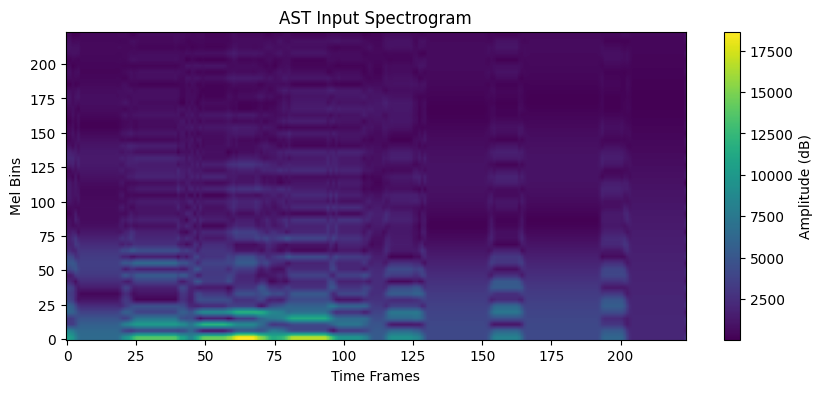

In [155]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 24 22:37:47 2024

@author: self
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 15 22:22:17 2021
@author: Parismita
"""
import numpy as np
#===============================================================
# RFA custom module import
import torch
import numpy as np
from torchvision.transforms.functional import resize
from torchvision.transforms import InterpolationMode

#===============================================================
#===============================================================


file = "chunked_dhi/Process-rec-001_PFT_chunk_0.wav"
specwindowsecs = 5
specstrides = 224

fm_spec = get_FM_spectrogram(file, specwindowsecs, specstrides)

am_spec = get_AM_spectrogram(file, specwindowsecs, specstrides)

tensor_fm = torch.tensor(fm_spec).float().unsqueeze(0)  # [1, 105, 30]
resized_fm = resize(
    tensor_fm, 
    size=(224, 224), 
    interpolation=InterpolationMode.BILINEAR
)

tensor_am = torch.tensor(am_spec).float().unsqueeze(0)  # [1, 105, 30]
resized_am = resize(
    tensor_am, 
    size=(224, 224), 
    interpolation=InterpolationMode.BILINEAR
)

resized_fm = resized_fm.squeeze(0) # use this a spectrogram
resized_am = resized_am.squeeze(0) # use this a spectrogram



# Visualize the spectrogram (transpose for proper orientation)
plt.figure(figsize=(10, 4))
plt.imshow(resized_fm.T, origin='lower', aspect='auto', cmap='viridis')
plt.title("AST Input Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Bins")
plt.colorbar(label="Amplitude (dB)")
plt.show()

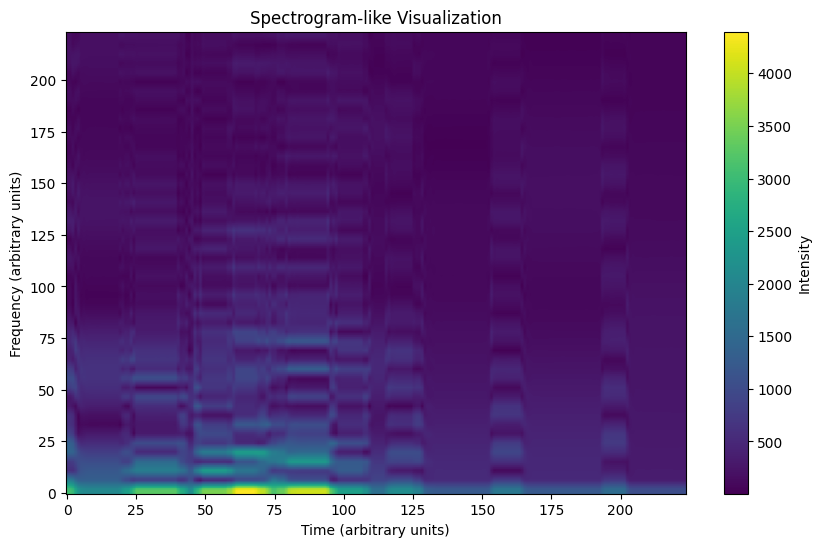

In [156]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the array as a spectrogram-like visualization
plt.figure(figsize=(10, 6))
plt.imshow(resized_am.T, aspect='auto', origin='lower', cmap='viridis')  # Customize 'cmap' for color scheme
plt.colorbar(label='Intensity')  # Add colorbar to show intensity values
plt.xlabel('Time (arbitrary units)')  # X-axis label
plt.ylabel('Frequency (arbitrary units)')  # Y-axis label
plt.title('Spectrogram-like Visualization')  # Title of the plot
plt.show()


In [157]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer, Wav2Vec2ForCTC, Wav2Vec2Processor
import timm  # For Vision Transformer
import torchaudio
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
import librosa
import librosa.display
import random


In [158]:
# Constants
NUM_CLASSES = 2
BERT_MODEL_NAME = 'bert-base-uncased'
AUDIO_SHAPE = (224, 224)
TEXT_MAX_LENGTH = 64
SEQ_LEN = 128

# Initialize models
vad_model = load_silero_vad()
asr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
asr_model.to(device)

# Load BERT and ViT model
bert = BertModel.from_pretrained(BERT_MODEL_NAME).to(device)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Identity()
vit_model.eval().to(device)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset

# Dataset class to load precomputed embeddings
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, embeddings_dir, iftrain, num_classes=10):
        self.data = dataframe
        self.embeddings_dir = embeddings_dir
        self.iftrain = iftrain
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        embeddings_path = os.path.join(self.embeddings_dir, f"{os.path.basename(row['audio_path'])}_embeddings.pth")
        embeddings = torch.load(embeddings_path)

        # No padding required, directly use embeddings
        viT_embeddings = embeddings['vit_embeddings'].squeeze(0)  # Shape: (1, 768) -> (768)
        input_ids = embeddings['bert_embeddings'].squeeze(0)  # Shape: (1, 768) -> (768)

        # Get the label
        label = torch.tensor(row['label'], dtype=torch.long)
        if label == 2 and label >= self.num_classes:
            label = torch.tensor(self.num_classes - 1, dtype=torch.long) 

        return row['audio_path'], viT_embeddings, input_ids, label

# Multimodal Model with Feed-Forward Layers
class MultimodalFeedForwardModel(nn.Module):
    def __init__(self, num_classes=10, hidden_size=256):
        super(MultimodalFeedForwardModel, self).__init__()
        self.vit_reduction = nn.Linear(768, hidden_size)
        self.bert_reduction = nn.Linear(768, hidden_size)
        self.vit_ff = nn.Linear(hidden_size, hidden_size)
        self.bert_ff = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(2 * hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, vit_embeddings, bert_embeddings):
        vit_embeddings = self.vit_reduction(vit_embeddings)
        bert_embeddings = self.bert_reduction(bert_embeddings)
        vit_processed = F.relu(self.vit_ff(vit_embeddings))
        bert_processed = F.relu(self.bert_ff(bert_embeddings))
        combined_features = torch.cat((vit_processed, bert_processed), dim=1)
        combined_features = self.dropout(combined_features)
        output = self.fc(combined_features)
        probabilities = F.softmax(output, dim=1)
        return probabilities, vit_processed, bert_processed, combined_features

In [160]:
import os
import random
import torch
import librosa
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm

def compute_deltas(spec):
    """Compute delta and double delta (delta-delta) of a spectrogram."""
    delta = librosa.feature.delta(spec)
    delta_delta = librosa.feature.delta(spec, order=2)
    return delta, delta_delta

def precompute_embeddings_v2(dataframe, save_dir, specwindowsecs=3, specstrides=224):
    os.makedirs(save_dir, exist_ok=True)

    fixed_df = pd.DataFrame(dataframe)

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Precomputing embeddings"):

        audio_path = row['audio_path']
        waveform, sr = librosa.load(audio_path, sr=16000)  # Load audio at 16kHz

        embeds_path = os.path.join(save_dir, f"{os.path.basename(audio_path)}_embeddings.pth")
        #if os.path.exists(embeds_path):
        #    continue

        viT_embeddings, bert_embeddings = [], []

        # Process input for ASR model
        inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            logits = asr_model(inputs.input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0].lower()

        if len(transcription.split()) < 1:
            transcription = "ok"

        # BERT Embedding - Use all hidden states
        tokenized_inputs = tokenizer(transcription, padding='max_length', truncation=True, max_length=TEXT_MAX_LENGTH, return_tensors='pt').to(device)
        with torch.no_grad():
             all_bert_embeddings = torch.mean(bert(input_ids=tokenized_inputs['input_ids'], attention_mask=tokenized_inputs['attention_mask']).last_hidden_state, dim=1)
        
        bert_embeddings.append(all_bert_embeddings)

        # Generate AM, FM, and Mel spectrograms
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=1024, hop_length=160, n_mels=256)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_tensor = torch.tensor(mel_spectrogram_db)
      
        delta, delta_delta = compute_deltas(mel_spectrogram_db)
        delta_tensor = torch.tensor(delta)
        delta_delta_tensor = torch.tensor(delta_delta)
        #print(mel_tensor.shape,delta.shape,delta_delta.shape)
        # Resize spectrograms to match required input size

        try:
            am_spectrogram = torch.tensor(get_AM_spectrogram(audio_path, specwindowsecs, specstrides)).T
        except:
            am_spectrogram = mel_tensor
        try:
            fm_spectrogram = torch.tensor(get_FM_spectrogram(audio_path, specwindowsecs, specstrides)).T
        except:
            fm_spectrogram = mel_tensor
        tensor_fm = torch.tensor(fm_spectrogram).float().unsqueeze(0)  # [1, 105, 30]

        delta_am, delta_delta_am = compute_deltas(am_spectrogram)
        delta_tensor_am = torch.tensor(delta_am)
        delta_delta_tensor_am = torch.tensor(delta_delta_am)
        resized_delta_am = resize(delta_tensor_am.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        resized_delta_delta_am = resize(delta_delta_tensor_am.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)

        delta_fm, delta_delta_fm = compute_deltas(fm_spectrogram)
        delta_tensor_fm = torch.tensor(delta_fm)
        delta_delta_tensor_fm = torch.tensor(delta_delta_fm)
        resized_delta_fm = resize(delta_tensor_fm.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        resized_delta_delta_fm = resize(delta_delta_tensor_fm.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        
        resized_fm = resize(tensor_fm, size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        
        tensor_am = torch.tensor(am_spectrogram).float().unsqueeze(0)  # [1, 105, 30]
        resized_am = resize(tensor_am, size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        
        tensor_mel = torch.tensor(mel_tensor).float().unsqueeze(0)  # [1, 105, 30]
        resized_mel = resize(tensor_mel, size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        #resized_mel = resize(mel_tensor.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        resized_delta = resize(delta_tensor.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        resized_delta_delta = resize(delta_delta_tensor.unsqueeze(0), size=(224, 224), interpolation=InterpolationMode.BILINEAR)
        #print(resized_mel.shape,resized_delta.shape,resized_delta_delta.shape)
        
        # Stack AM, FM, and Mel spectrograms as channels
        #spectrogram_tensor = torch.stack([resized_am, resized_fm, resized_mel]).squeeze(1)  # Shape [3, 224, 224]
        #spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # Add batch dimension
        
        spectrogram_tensor = torch.stack([resized_fm, resized_delta_fm, resized_delta_delta_fm]).squeeze(1)  # Shape [3, 224, 224]
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # Add batch dimension

        # ViT Embedding - Use all embeddings
        with torch.no_grad():
            viT_output = vit_model(spectrogram_tensor.float().to(device))

        # Save embeddings
        try:
            embedding_dict = {
                'bert_embeddings': (all_bert_embeddings).cpu(),
                'vit_embeddings': (viT_output).cpu()
            }
            torch.save(embedding_dict, embeds_path)
        except Exception as e:
            print("Dropping row. Error in extracting embeddings!", e)
            fixed_df = fixed_df.drop(index)
            continue

    return fixed_df


In [161]:
run_dir  = "/scratch/project_2007260/ADReSSo/ADReSSo21/Dhinirnaya_chunk/runs_dir/concat_vx"
embeds_dir = os.path.join(root_data_dir, "concat_embeds")
os.makedirs(embeds_dir, exist_ok=True)

In [63]:
#### run 5 times with different seed and mean and std

In [64]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import logging
logging.getLogger().setLevel(logging.ERROR)

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Define loss function
def weighted_cross_entropy_loss(class_weights, device):
    return nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    
    for _, viT_embeddings, input_ids, labels in dataloader:
        viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _, _, _ = model(viT_embeddings, input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
        total_preds += labels.size(0)
    
    return running_loss / len(dataloader), correct_preds / total_preds

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for _, viT_embeddings, input_ids, labels in dataloader:
            viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
            outputs, _, _, _ = model(viT_embeddings, input_ids)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return {
        "loss": running_loss / len(dataloader),
        "accuracy": correct_preds / total_preds,
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted')
    }

# Main function
def main():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_df = pd.read_csv(os.path.join(root_data_dir, 'train_adresso_concat.csv'))
  test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))

  train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings') # os.path.join(embeds_dir, 'train_embeddings'), os,.path.join(embeds_dir, 'train_embeddings_mel_mel_mel'),
  test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings')   # os.path.join(embeds_dir, 'test_embeddings')

  train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
  test_df = precompute_embeddings_v2(test_df, test_embeds_dir)
    
  train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
  test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)
    
  SEEDS = [1,3,4]
  seed_metric = []  
  for SEED in SEEDS:
    print("For SEED:",SEED)  
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    best_models = [] 
    for fold, (train_idx, dev_idx) in enumerate(kfold.split(train_df)):
        print(f"Training on Fold {fold+1}")
        train_subset = Subset(train_dataset, train_idx)
        dev_subset = Subset(train_dataset, dev_idx)
        
        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
        dev_loader = DataLoader(dev_subset, batch_size=16, shuffle=False)
        
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device) ##[1.0, 2.05]
        criterion = weighted_cross_entropy_loss([1.0, 2.05], device)
        optimizer = optim.Adam(model.parameters(), lr=8e-5)
        
        best_metrics = {"accuracy": 0.0}
        best_model_state = None
        num_epochs = 100
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_metrics = validate_model(model, dev_loader, criterion, device)
            #print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, Prec.: {val_metrics['precision']:.4f}, Rec.: {val_metrics['recall']:.4f}")
            if val_metrics['accuracy'] > best_metrics['accuracy']:
                best_metrics = val_metrics
                best_model_state = model.state_dict()
        
        best_models.append(best_model_state)
    
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    for i, model_state in enumerate(best_models):
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        model.load_state_dict(model_state)
        test_metrics = validate_model(model, test_loader, criterion, device)
        print(f"Fold {i+1} Test Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, Prec.: {test_metrics['precision']:.4f}, Rec.: {test_metrics['recall']:.4f}")
    
    avg_model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
    avg_state_dict = avg_model.state_dict()
    
    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([torch.tensor(best_models[i][key]) for i in range(5)]).mean(dim=0)
    
    avg_model.load_state_dict(avg_state_dict)
    final_metrics = validate_model(avg_model, test_loader, criterion, device)
    print(f"Final Averaged Model Test Acc: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1']:.4f}, Prec.: {final_metrics['precision']:.4f}, Rec.: {final_metrics['recall']:.4f}")
    seed_metric.append(final_metrics)

  # Compute mean and standard deviation of metrics across different seeds
  seed_accuracies = [metric['accuracy'] for metric in seed_metric]
  seed_f1s = [metric['f1'] for metric in seed_metric]
  seed_precisions = [metric['precision'] for metric in seed_metric]
  seed_recalls = [metric['recall'] for metric in seed_metric]

  print("\nFinal Metrics Across Seeds:")
  print(f"Accuracy: Mean = {np.mean(seed_accuracies):.4f}, Std = {np.std(seed_accuracies):.4f}")
  print(f"F1 Score: Mean = {np.mean(seed_f1s):.4f}, Std = {np.std(seed_f1s):.4f}")
  print(f"Precision: Mean = {np.mean(seed_precisions):.4f}, Std = {np.std(seed_precisions):.4f}")
  print(f"Recall: Mean = {np.mean(seed_recalls):.4f}, Std = {np.std(seed_recalls):.4f}")
 
if __name__ == '__main__':
    main()


Precomputing embeddings: 100%|██████████| 70/70 [01:41<00:00,  1.44s/it]


For SEED: 1
Training on Fold 1
Training on Fold 2
Training on Fold 3
Training on Fold 4
Training on Fold 5
Fold 1 Test Acc: 0.7000, F1: 0.6994, Prec.: 0.7015, Rec.: 0.7000
Fold 2 Test Acc: 0.6571, F1: 0.6468, Prec.: 0.6781, Rec.: 0.6571
Fold 3 Test Acc: 0.6714, F1: 0.6681, Prec.: 0.6786, Rec.: 0.6714
Fold 4 Test Acc: 0.7000, F1: 0.6893, Prec.: 0.7320, Rec.: 0.7000
Fold 5 Test Acc: 0.6429, F1: 0.6369, Prec.: 0.6530, Rec.: 0.6429
Final Averaged Model Test Acc: 0.6571, F1: 0.6546, Prec.: 0.6619, Rec.: 0.6571
For SEED: 3
Training on Fold 1
Training on Fold 2
Training on Fold 3
Training on Fold 4
Training on Fold 5
Fold 1 Test Acc: 0.6714, F1: 0.6708, Prec.: 0.6727, Rec.: 0.6714
Fold 2 Test Acc: 0.6571, F1: 0.6526, Prec.: 0.6658, Rec.: 0.6571
Fold 3 Test Acc: 0.7000, F1: 0.6893, Prec.: 0.7320, Rec.: 0.7000
Fold 4 Test Acc: 0.6143, F1: 0.6104, Prec.: 0.6190, Rec.: 0.6143
Fold 5 Test Acc: 0.6857, F1: 0.6762, Prec.: 0.7105, Rec.: 0.6857
Final Averaged Model Test Acc: 0.6571, F1: 0.6500, Prec.:

In [ ]:
#####################With Specificity + Sensitivity##################################

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import logging
logging.getLogger().setLevel(logging.ERROR)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Weighted loss
def weighted_cross_entropy_loss(class_weights, device):
    return nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Training loop
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    for _, viT_embeddings, input_ids, labels in dataloader:
        viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _, _, _ = model(viT_embeddings, input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
        total_preds += labels.size(0)
    return running_loss / len(dataloader), correct_preds / total_preds

# Validation loop with specificity and sensitivity
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for _, viT_embeddings, input_ids, labels in dataloader:
            viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
            outputs, _, _, _ = model(viT_embeddings, input_ids)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    num_classes = cm.shape[0]
    sensitivities, specificities = [], []
    #print(cm)
    for i in range(1):
        TP = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        TN = cm[1, 1]
        

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        #print(TP,FN,FP,TN,sensitivity,specificity)

    return {
        "loss": running_loss / len(dataloader),
        "accuracy": correct_preds / total_preds,
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted'),
        "sensitivity": np.mean(sensitivities),
        "specificity": np.mean(specificities)
    }

# Main loop
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_csv(os.path.join(root_data_dir, 'train_adresso_concat.csv'))
    test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))

    train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings')
    test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings')

    train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
    test_df = precompute_embeddings_v2(test_df, test_embeds_dir)

    train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
    test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)

    SEEDS = [1,7,4] #[1, 3, 4]
    seed_metric = []

    for SEED in SEEDS:
        print("For SEED:", SEED)
        kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
        best_models = []

        for fold, (train_idx, dev_idx) in enumerate(kfold.split(train_df)):
            print(f"Training on Fold {fold+1}")
            train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=16, shuffle=True)
            dev_loader = DataLoader(Subset(train_dataset, dev_idx), batch_size=16, shuffle=False)

            model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
            criterion = weighted_cross_entropy_loss([1.0, 2.05], device)
            optimizer = optim.Adam(model.parameters(), lr=8e-5)

            best_metrics = {"accuracy": 0.0}
            best_model_state = None

            for epoch in range(100):
                train_model(model, train_loader, optimizer, criterion, device)
                val_metrics = validate_model(model, dev_loader, criterion, device)
                if val_metrics['accuracy'] > best_metrics['accuracy']:
                    best_metrics = val_metrics
                    best_model_state = model.state_dict()

            best_models.append(best_model_state)

        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        for i, model_state in enumerate(best_models):
            model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
            model.load_state_dict(model_state)
            test_metrics = validate_model(model, test_loader, criterion, device)
            print(f"Fold {i+1} Test Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, "
                  f"Prec.: {test_metrics['precision']:.4f}, Rec/Sens.: {test_metrics['sensitivity']:.4f}, "
                  f"Spec.: {test_metrics['specificity']:.4f}")

        # Averaged model
        avg_model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        avg_state_dict = avg_model.state_dict()
        for key in avg_state_dict.keys():
            avg_state_dict[key] = torch.stack([torch.tensor(best_models[i][key]) for i in range(5)]).mean(dim=0)
        avg_model.load_state_dict(avg_state_dict)
        final_metrics = validate_model(avg_model, test_loader, criterion, device)
        print(f"Final Averaged Model Test Acc: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1']:.4f}, "
              f"Prec.: {final_metrics['precision']:.4f}, Rec/Sens.: {final_metrics['sensitivity']:.4f}, "
              f"Spec.: {final_metrics['specificity']:.4f}")
        seed_metric.append(final_metrics)

    # Summary
    print("\nFinal Metrics Across Seeds:")
    for metric_name in ['accuracy', 'f1', 'precision', 'sensitivity', 'specificity']:
        values = [m[metric_name] for m in seed_metric]
        print(f"{metric_name.capitalize()}: Mean = {np.mean(values):.4f}, Std = {np.std(values):.4f}")

if __name__ == '__main__':
    main()


Precomputing embeddings: 100%|██████████| 70/70 [01:59<00:00,  1.71s/it]


For SEED: 1
Training on Fold 1
Training on Fold 2
Training on Fold 3
Training on Fold 4
Training on Fold 5
Fold 1 Test Acc: 0.7857, F1: 0.7853, Prec.: 0.7878, Rec/Sens.: 0.8125, Spec.: 0.7632
Fold 2 Test Acc: 0.7429, F1: 0.7410, Prec.: 0.7502, Rec/Sens.: 0.7931, Spec.: 0.7073
Fold 3 Test Acc: 0.7571, F1: 0.7567, Prec.: 0.7590, Rec/Sens.: 0.7812, Spec.: 0.7368
Fold 4 Test Acc: 0.7143, F1: 0.7141, Prec.: 0.7150, Rec/Sens.: 0.7027, Spec.: 0.7273
Fold 5 Test Acc: 0.7429, F1: 0.7351, Prec.: 0.7752, Rec/Sens.: 0.8696, Spec.: 0.6809
Final Averaged Model Test Acc: 0.7857, F1: 0.7853, Prec.: 0.7878, Rec/Sens.: 0.8125, Spec.: 0.7632
For SEED: 7
Training on Fold 1


In [ ]:
###t-sne

Precomputing embeddings: 100%|██████████| 70/70 [02:04<00:00,  1.78s/it]


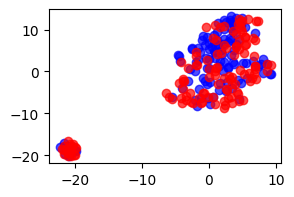

In [65]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

# Load dataset
train_df = pd.read_csv(os.path.join(root_data_dir, 'train_adresso_concat.csv'))
test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))

train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings')
test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings')

train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
test_df = precompute_embeddings_v2(test_df, test_embeds_dir)

train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def extract_embeddings(dataloader, device):
    vit_embeddings, bert_embeddings, labels = [], [], []
    for _, viT_embeds, bert_embeds, label in dataloader:
        vit_embeddings.append(viT_embeds.numpy())
        bert_embeddings.append(bert_embeds.numpy())
        labels.append(label.numpy())
    
    vit_embeddings = np.vstack(vit_embeddings)
    bert_embeddings = np.vstack(bert_embeddings)
    labels = np.hstack(labels)
    
    combined_embeddings = np.hstack((vit_embeddings, bert_embeddings))
    return combined_embeddings, labels

#def plot_tsne(embeddings, labels):
#    tsne = TSNE(n_components=2, random_state=42)
#    reduced_embeddings = tsne.fit_transform(embeddings)
    
#    plt.figure(figsize=(8, 6))
#    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
#    plt.colorbar(label='Label')
#    #plt.title('t-SNE of ViT & BERT Embeddings')
#    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(3, 2))
    
    # Define label mapping and colors
    label_map = {0: 'HC', 1: 'Dementia'}
    colors = ['blue', 'red']
    
    # Scatter plot with labels
    for label, color in zip(label_map.keys(), colors):
        indices = np.where(labels == label)
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                    c=color, label=label_map[label], alpha=0.7)
    
    #plt.xlabel("t-SNE Component 1",font=12)
    #plt.ylabel("t-SNE Component 2")
    plt.show()

# Extract embeddings and plot t-SNE
train_embeddings, train_labels = extract_embeddings(train_loader, torch.device("cpu"))
test_embeddings, test_labels = extract_embeddings(test_loader, torch.device("cpu"))

plot_tsne(np.vstack((train_embeddings, test_embeddings)), np.hstack((train_labels, test_labels)))


In [105]:
##without tqdm

In [106]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import logging
logging.getLogger().setLevel(logging.ERROR)

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Define loss function
def weighted_cross_entropy_loss(class_weights, device):
    return nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    
    for _, viT_embeddings, input_ids, labels in dataloader:
        viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _, _, _ = model(viT_embeddings, input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
        total_preds += labels.size(0)
    
    return running_loss / len(dataloader), correct_preds / total_preds

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for _, viT_embeddings, input_ids, labels in dataloader:
            viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
            outputs, _, _, _ = model(viT_embeddings, input_ids)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return {
        "loss": running_loss / len(dataloader),
        "accuracy": correct_preds / total_preds,
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted')
    }

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_csv(os.path.join(root_data_dir, 'train_adresso_concat.csv'))
    test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))

    train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings_am_am_am') # os.path.join(embeds_dir, 'train_embeddings'), os,.path.join(embeds_dir, 'train_embeddings_mel_mel_mel'),
    test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings_am_am_am')   # os.path.join(embeds_dir, 'test_embeddings')

    train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
    test_df = precompute_embeddings_v2(test_df, test_embeds_dir)
    
    train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
    test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    best_models = []
    
    for fold, (train_idx, dev_idx) in enumerate(kfold.split(train_df)):
        print(f"Training on Fold {fold+1}")
        train_subset = Subset(train_dataset, train_idx)
        dev_subset = Subset(train_dataset, dev_idx)
        
        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
        dev_loader = DataLoader(dev_subset, batch_size=16, shuffle=False)
        
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device) ##[1.0, 2.05]
        criterion = weighted_cross_entropy_loss([1.0, 2.05], device)
        optimizer = optim.Adam(model.parameters(), lr=8e-5)
        
        best_metrics = {"accuracy": 0.0}
        best_model_state = None
        num_epochs = 100
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_metrics = validate_model(model, dev_loader, criterion, device)
            #print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, Prec.: {val_metrics['precision']:.4f}, Rec.: {val_metrics['recall']:.4f}")
            if val_metrics['accuracy'] > best_metrics['accuracy']:
                best_metrics = val_metrics
                best_model_state = model.state_dict()
        
        best_models.append(best_model_state)
    
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    for i, model_state in enumerate(best_models):
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        model.load_state_dict(model_state)
        test_metrics = validate_model(model, test_loader, criterion, device)
        print(f"Fold {i+1} Test Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, Prec.: {test_metrics['precision']:.4f}, Rec.: {test_metrics['recall']:.4f}")
    
    avg_model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
    avg_state_dict = avg_model.state_dict()
    
    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([torch.tensor(best_models[i][key]) for i in range(5)]).mean(dim=0)
    
    avg_model.load_state_dict(avg_state_dict)
    final_metrics = validate_model(avg_model, test_loader, criterion, device)
    print(f"Final Averaged Model Test Acc: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1']:.4f}, Prec.: {final_metrics['precision']:.4f}, Rec.: {final_metrics['recall']:.4f}")

if __name__ == '__main__':
    main()


Precomputing embeddings: 100%|██████████| 70/70 [01:41<00:00,  1.46s/it]


Training on Fold 1
Training on Fold 2
Training on Fold 3
Training on Fold 4
Training on Fold 5
Fold 1 Test Acc: 0.6857, F1: 0.6847, Prec.: 0.6882, Rec.: 0.6857
Fold 2 Test Acc: 0.6714, F1: 0.6659, Prec.: 0.6836, Rec.: 0.6714
Fold 3 Test Acc: 0.7286, F1: 0.7217, Prec.: 0.7536, Rec.: 0.7286
Fold 4 Test Acc: 0.7143, F1: 0.7083, Prec.: 0.7333, Rec.: 0.7143
Fold 5 Test Acc: 0.6714, F1: 0.6597, Prec.: 0.6989, Rec.: 0.6714
Final Averaged Model Test Acc: 0.7571, F1: 0.7571, Prec.: 0.7574, Rec.: 0.7571


In [ ]:
##### with 80:20

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import logging
logging.getLogger().setLevel(logging.ERROR)

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Define loss function
def weighted_cross_entropy_loss(class_weights, device):
    return nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    
    for _, viT_embeddings, input_ids, labels in dataloader:
        viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _, _, _ = model(viT_embeddings, input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
        total_preds += labels.size(0)
    
    return running_loss / len(dataloader), correct_preds / total_preds

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for _, viT_embeddings, input_ids, labels in dataloader:
            viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
            outputs, _, _, _ = model(viT_embeddings, input_ids)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return {
        "loss": running_loss / len(dataloader),
        "accuracy": correct_preds / total_preds,
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted')
    }

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_csv(os.path.join(root_data_dir, 'train_adresso_concat.csv'))
    test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))

    train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings')
    test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings')

    train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
    test_df = precompute_embeddings_v2(test_df, test_embeds_dir)
    
    train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
    test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    best_models = []
    
    for fold, (train_idx, dev_idx) in enumerate(kfold.split(train_df)):
        train_size = int(0.9 * len(train_idx))
        dev_size = len(train_idx) - train_size
        train_subset, dev_subset = torch.utils.data.random_split(Subset(train_dataset, train_idx), [train_size, dev_size])
        
        print(f"Training on Fold {fold+1}")
        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
        dev_loader = DataLoader(dev_subset, batch_size=16, shuffle=False)
        
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        criterion = weighted_cross_entropy_loss([1.0, 2.05], device)
        optimizer = optim.Adam(model.parameters(), lr=8e-5)
        
        best_metrics = {"accuracy": 0.0}
        best_model_state = None
        num_epochs = 250
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_metrics = validate_model(model, dev_loader, criterion, device)
            #print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, Prec.: {val_metrics['precision']:.4f}, Rec.: {val_metrics['recall']:.4f}")
            if val_metrics['accuracy'] > best_metrics['accuracy']:
                best_metrics = val_metrics
                best_model_state = model.state_dict()
        
        best_models.append(best_model_state)
    
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    for i, model_state in enumerate(best_models):
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        model.load_state_dict(model_state)
        test_metrics = validate_model(model, test_loader, criterion, device)
        print(f"Fold {i+1} Test Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, Prec.: {test_metrics['precision']:.4f}, Rec.: {test_metrics['recall']:.4f}")
    
    avg_model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
    avg_state_dict = avg_model.state_dict()
    
    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([torch.tensor(best_models[i][key]) for i in range(5)]).mean(dim=0)
    
    avg_model.load_state_dict(avg_state_dict)
    final_metrics = validate_model(avg_model, test_loader, criterion, device)
    print(f"Final Averaged Model Test Acc: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1']:.4f}, Prec.: {final_metrics['precision']:.4f}, Rec.: {final_metrics['recall']:.4f}")

if __name__ == '__main__':
    main()


In [ ]:
###with tqdm

In [24]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm

import logging
logging.getLogger().setLevel(logging.ERROR)


# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Define loss function
def weighted_cross_entropy_loss(class_weights, device):
    return nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    
    for _, viT_embeddings, input_ids, labels in tqdm(dataloader, desc='Training'):
        viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _, _, _ = model(viT_embeddings, input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
        total_preds += labels.size(0)
    
    return running_loss / len(dataloader), correct_preds / total_preds

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for _, viT_embeddings, input_ids, labels in dataloader:
            viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
            outputs, _, _, _ = model(viT_embeddings, input_ids)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return {
        "loss": running_loss / len(dataloader),
        "accuracy": correct_preds / total_preds,
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted')
    }

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_csv(os.path.join(root_data_dir, 'train_adresso_concat.csv'))
    test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))

    train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings')
    test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings')

    train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
    test_df = precompute_embeddings_v2(test_df, test_embeds_dir)
    
    train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
    test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    best_models = []
    
    for fold, (train_idx, dev_idx) in enumerate(kfold.split(train_df)):
        print(f"Training on Fold {fold+1}")
        train_subset = Subset(train_dataset, train_idx)
        dev_subset = Subset(train_dataset, dev_idx)
        
        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
        dev_loader = DataLoader(dev_subset, batch_size=16, shuffle=False)
        
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        criterion = weighted_cross_entropy_loss([1.0, 2.05], device)
        optimizer = optim.Adam(model.parameters(), lr=8e-5)
        
        best_metrics = {"accuracy": 0.0}
        best_model_state = None
        num_epochs = 100
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_metrics = validate_model(model, dev_loader, criterion, device)
            
            #print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, Prec.: {val_metrics['precision']:.4f}, Rec.: {val_metrics['recall']:.4f}")
            
            if val_metrics['accuracy'] > best_metrics['accuracy']:
                best_metrics = val_metrics
                best_model_state = model.state_dict()
        
        best_models.append(best_model_state)
    
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    for i, model_state in enumerate(best_models):
        model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
        model.load_state_dict(model_state)
        test_metrics = validate_model(model, test_loader, criterion, device)
        print(f"Fold {i+1} Test Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, Prec.: {test_metrics['precision']:.4f}, Rec.: {test_metrics['recall']:.4f}")
    
    avg_model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
    avg_state_dict = avg_model.state_dict()
    
    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([torch.tensor(best_models[i][key]) for i in range(5)]).mean(dim=0)
    
    avg_model.load_state_dict(avg_state_dict)
    final_metrics = validate_model(avg_model, test_loader, criterion, device)
    print(f"Final Averaged Model Test Acc: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1']:.4f}, Prec.: {final_metrics['precision']:.4f}, Rec.: {final_metrics['recall']:.4f}")

if __name__ == '__main__':
    main()

Precomputing embeddings: 100%|██████████| 70/70 [00:00<00:00, 243.15it/s]


Training on Fold 1


Training:  12%|█▎        | 1/8 [00:00<00:00, 54.63it/s]


KeyboardInterrupt: 

In [ ]:
###without k-fold

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm

# Define loss function
def weighted_cross_entropy_loss(class_weights, device):
    return nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    
    for _, viT_embeddings, input_ids, labels in tqdm(dataloader, desc='Training'):
        viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, it, text, att = model(viT_embeddings, input_ids)
        #print(outputs,labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
        total_preds += labels.size(0)
    
    return running_loss / len(dataloader), correct_preds / total_preds

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for _, viT_embeddings, input_ids, labels in dataloader:
            viT_embeddings, input_ids, labels = viT_embeddings.to(device), input_ids.to(device), labels.to(device)
            outputs, it, text, att = model(viT_embeddings, input_ids)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return {
        "loss": running_loss / len(dataloader),
        "accuracy": correct_preds / total_preds,
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted')
    }

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_df = pd.read_csv(os.path.join(root_data_dir,'train_adresso_concat.csv'))
    test_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso_concat.csv'))
    # adresso_df = pd.read_csv(os.path.join(root_data_dir, 'dev_adresso.csv'))

    train_embeds_dir = os.path.join(embeds_dir, 'train_embeddings')
    test_embeds_dir = os.path.join(embeds_dir, 'test_embeddings')

    train_df = precompute_embeddings_v2(train_df, train_embeds_dir)
    test_df = precompute_embeddings_v2(test_df, test_embeds_dir)
    
    train_dataset = MultimodalDataset(train_df, train_embeds_dir, iftrain=1, num_classes=NUM_CLASSES)
    test_dataset = MultimodalDataset(test_df, test_embeds_dir, iftrain=0, num_classes=NUM_CLASSES)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    model = MultimodalFeedForwardModel(num_classes=NUM_CLASSES).to(device)
    criterion = weighted_cross_entropy_loss([1.0, 2.05], device)
    optimizer = optim.Adam(model.parameters(), lr=8e-5)
    
    num_epochs = 500
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_metrics = validate_model(model, test_loader, criterion, device)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {val_metrics['accuracy']:.4f},Test F1: {val_metrics['f1']:.4f},Test Prec.: {val_metrics['precision']:.4f},Test Rec.: {val_metrics['recall']:.4f}")

if __name__ == '__main__':
    main()
